<a href="https://colab.research.google.com/github/taliafabs/STA496/blob/main/MidtermPaper/code/STA496_MidtermPaperCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA496 Midterm Paper Code

In [263]:
# Workplace setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pymc as pm
import random
from scipy import stats
from scipy.stats.distributions import chi2

## Data

### Load data

In [58]:
# ces 2024
# ces24_url = "https://raw.githubusercontent.com/taliafabs/STA496/c081804df5e98000c7e74493087f3d4b8b39db2b/MidtermPaper/data/ces24_analysis_data.parquet"
url = "https://raw.githubusercontent.com/taliafabs/STA496/f2606bb9f82da6cc538e5f02998c73ee75dd13c7/MidtermPaper/data/ces24_analysis_data.parquet"
ces24_df = pd.read_parquet(url, engine="pyarrow")

In [265]:
ces24_df.head()

,vote_trump,presvote24,race,age_bracket,birthyr,hispanic,gender4,educ,state,region,urbancity,econ_past_year,family_income_past_year,price_change_past_year,biden_approval,tookpost
0,0,Kamala Harris (D),Black,45–54,1978,No,Woman,High school graduate,Pennsylvania,Northeast,City,Stayed about the same,Stayed about the same,Stayed about the same,Strongly approve,Yes
1,0,Kamala Harris (D),Hispanic,55–64,1968,Yes,Man,4-year,New York,Northeast,City,Gotten much better,Stayed about the same,Increased somewhat,Strongly approve,Yes
2,0,Kamala Harris (D),White,75+,1946,No,Woman,2-year,Pennsylvania,Northeast,Suburb,Gotten much better,Stayed about the same,Decreased somewhat,Strongly approve,Yes
3,0,Kamala Harris (D),White,18–24,2001,Yes,Woman,High school graduate,California,West,Suburb,Gotten much worse,Stayed about the same,Increased a lot,Strongly disapprove,Yes
4,0,Other,White,65–74,1955,No,Woman,High school graduate,Montana,West,Town,Gotten much worse,Stayed about the same,Increased a lot,Somewhat disapprove,Yes


In [3]:
# 2024 election results
results24_url = "https://raw.githubusercontent.com/taliafabs/STA496/c081804df5e98000c7e74493087f3d4b8b39db2b/MidtermPaper/data/pres24_results_data.parquet"
results24_df = pd.read_parquet(results24_url, engine="pyarrow")

### Variables and helper functions

In [69]:
# colors
dem_blue = "#083A90"
gop_red = "#E9141D"
other = 'darkgray'

In [ ]:
# stacked bar plot using matplotlib
def plot_stacked_bar(pct_df, figsize=(10, 6), label_fontsize=10, tick_fontsize=8,
                     legend_fontsize=9, title='', legend_position = (0.5, -0.07),
                     legend_ncol=3):
    """
    Plots a stacked bar visualization to show trump and harris percentages.
    Input:
      - pct_dataframe: pandas dataframe with trump and harris percentages
    Output:
      - stacked bar plot
    """
    new_plot = pct_df.plot(
        kind='barh',
        stacked=True,
        color=[colors[col] for col in pct_df.columns],
        figsize=figsize
    )
    new_plot.set_xticks([])

    for i, (index, row) in enumerate(pct_df.iterrows()):
        cum_width = 0
        for col in pct_df.columns:
            value = row[col]
            new_plot.text(
                cum_width + value / 2,  # center of the bar segment
                i,                      # bar index
                f'{value:.1f}%',        # label text
                va='center',
                ha='center',
                color='white',
                fontsize=6,
                fontweight='bold'
            )
            cum_width += value

    plt.axvline(x=50, color='#de89ff', linestyle='--', linewidth=1.2)

    # Add label for the 50% line
    ymax = len(pct_df) - 0.5
    plt.text(50, -0.65, '50%', color='#de89ff', fontsize=label_fontsize, va='bottom', fontweight='bold')

    plt.legend(
        title='',                     # Optional: remove legend title
        loc='upper center',           # Center the legend horizontally
        bbox_to_anchor=legend_position, # Shift it below the axes
        borderaxespad=0.0,
        ncol=legend_ncol                       # Spread legend items across columns
    )
    plt.title(title, fontsize=12)
    plt.xlabel('')
    plt.show()

In [ ]:
# faceted bar plot using seaborn.sns
def sns_bar_plot():
  pass

### Exploratory data analysis

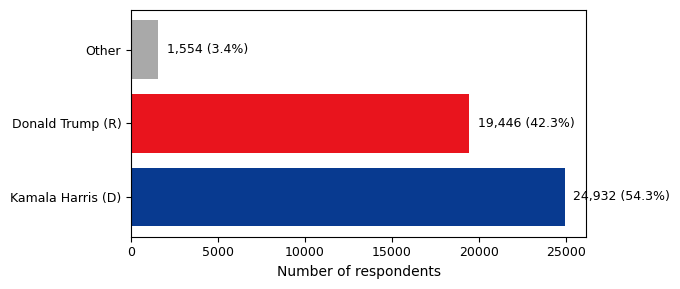

In [68]:
# horizontal bar plot to show the breakdown of harris and trump voters in the
# 2024 ces survey dataset
# write the caption in overleaf
vote_counts = ces24_df['presvote24'].value_counts()
vote_pct = vote_counts / vote_counts.sum() * 100
colors = vote_counts.index.map({
    'Donald Trump (R)': gop_red,
    'Kamala Harris (D)': dem_blue,
    'Other': other
})
plt.figure(figsize=(7, 3))
plt.barh(vote_counts.index, vote_counts.values, color=colors)
# plt.title('CES 2024 Vote Counts and Percentages')
plt.xlabel('Number of respondents')
for i, (count, pct) in enumerate(zip(vote_counts, vote_pct)):
    plt.text(count + 500, i, f'{count:,} ({pct:.1f}%)', va='center', fontsize=9)
plt.tight_layout()
# make x and y axis text smaller
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

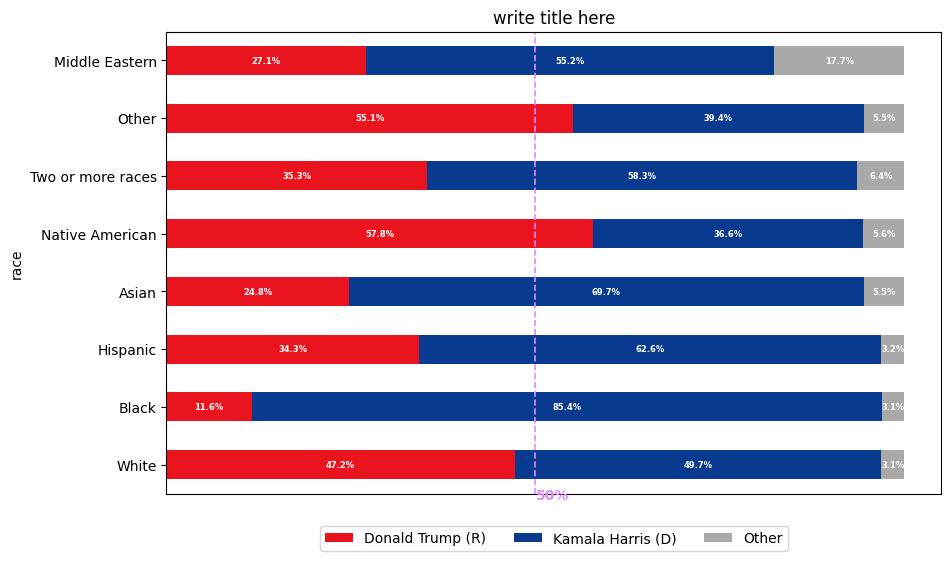

In [233]:
# race
race_vote_counts = pd.crosstab(ces24_df['race'], ces24_df['presvote24'])
race_vote_prop = race_vote_counts.div(race_vote_counts.sum(axis=1), axis=0)
race_vote_pct = race_vote_prop * 100
title="write title here"
plot_stacked_bar(race_vote_pct, title=title)

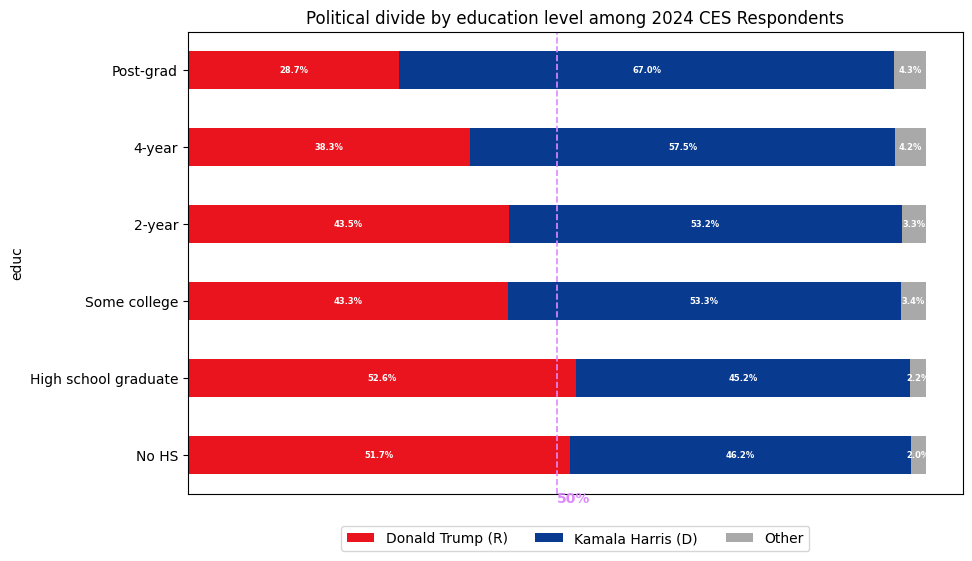

In [231]:
# educational divide
educ_vote_counts = pd.crosstab(ces24_df['educ'], ces24_df['presvote24'])
educ_vote_prop = educ_vote_counts.div(educ_vote_counts.sum(axis=1), axis=0)
educ_vote_pct = educ_vote_prop * 100
title="Political divide by education level among 2024 CES Respondents"
plot_stacked_bar(educ_vote_pct, title=title)

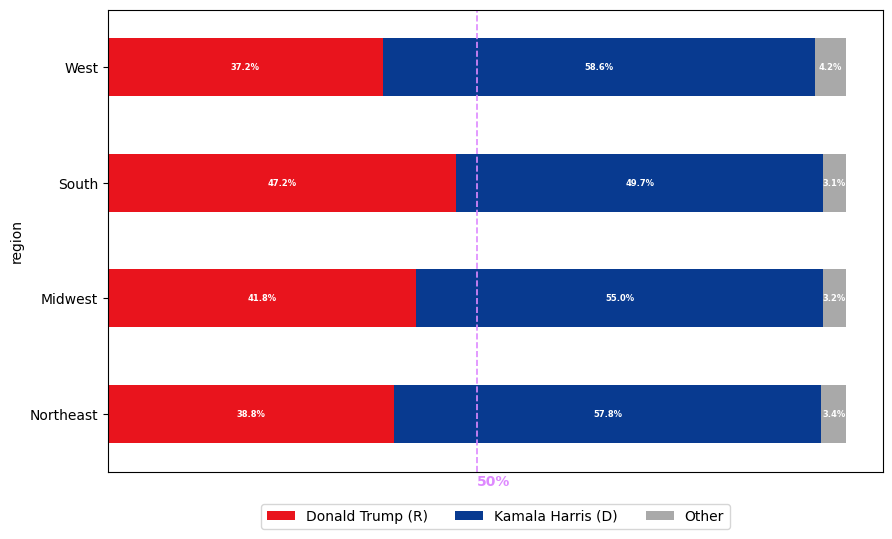

In [227]:
# region
region_vote_counts = pd.crosstab(ces24_df['region'], ces24_df['presvote24'])
region_vote_prop = region_vote_counts.div(region_vote_counts.sum(axis=1), axis=0)
region_vote_pct = region_vote_prop * 100
plot_stacked_bar(region_vote_pct)

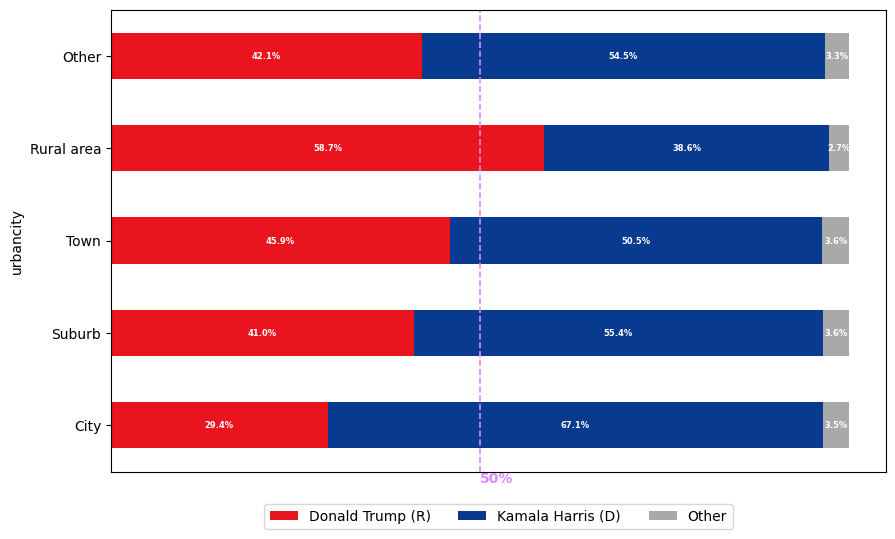

In [228]:
# urban rural divide
urban_vote_counts = pd.crosstab(ces24_df['urbancity'], ces24_df['presvote24'])
urban_vote_prop = urban_vote_counts.div(urban_vote_counts.sum(axis=1), axis=0)
urban_vote_pct = urban_vote_prop * 100
plot_stacked_bar(urban_vote_pct)

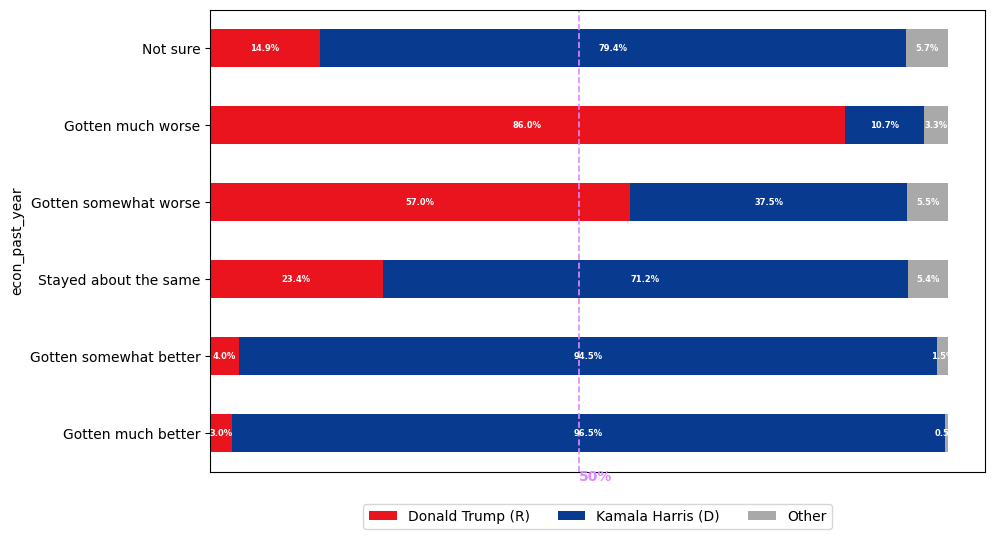

In [268]:
# perception of the economy
econ_counts = pd.crosstab(ces24_df['econ_past_year'], ces24_df['presvote24'])
econ_prop = econ_counts.div(econ_counts.sum(axis=1), axis=0)
econ_pct = econ_prop * 100
plot_stacked_bar(econ_pct)

In [ ]:
# biden approval
biden_app_counts = pd.crosstab()

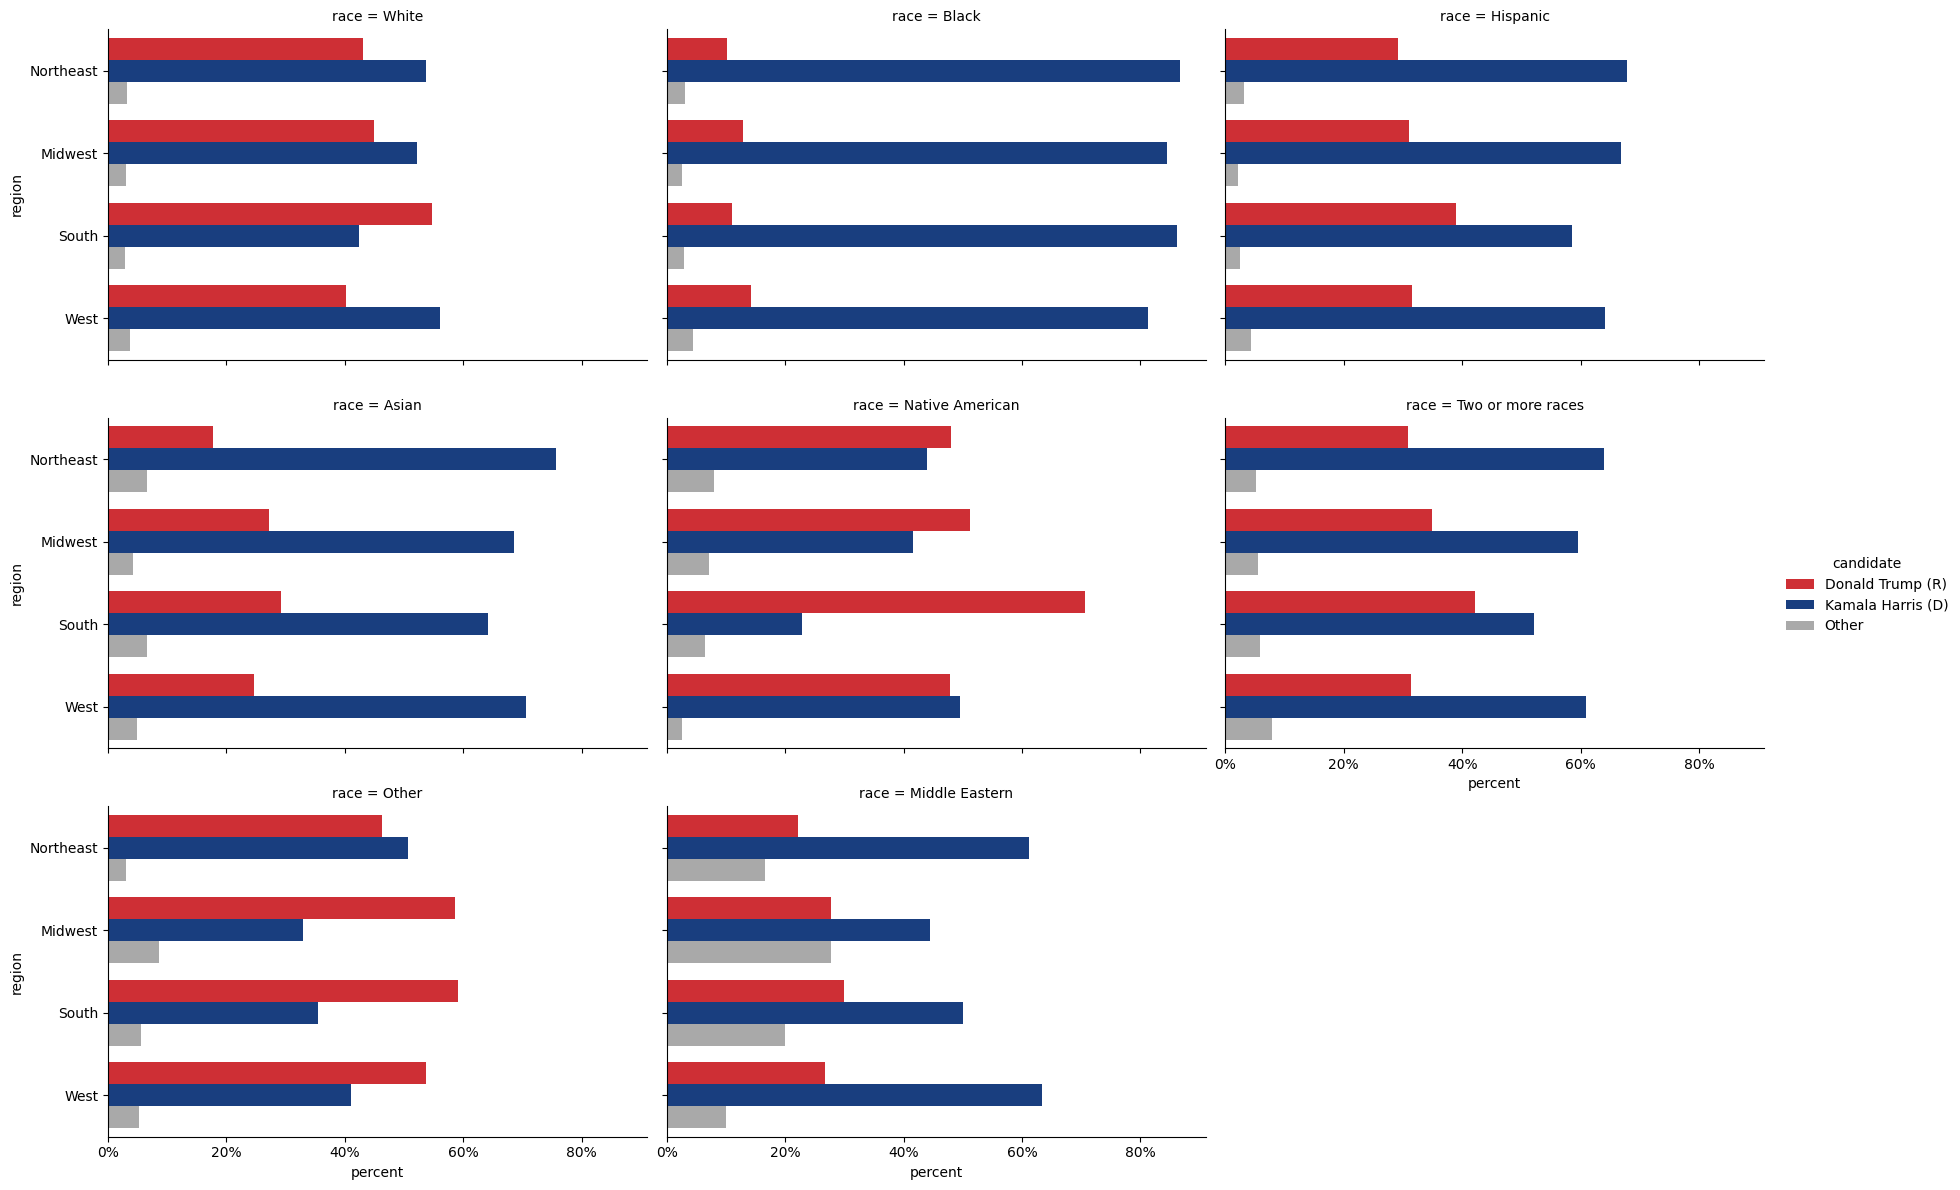

In [264]:
# race and region
race_region_vote_counts = pd.crosstab([ces24_df['region'], ces24_df['race']], ces24_df['presvote24'])
race_region_vote_prop = race_region_vote_counts.div(race_region_vote_counts.sum(axis=1), axis=0)
race_region_vote_pct = race_region_vote_prop * 100
race_region_vote_long = race_region_vote_pct.reset_index().melt(
    id_vars=['region', 'race'],
    var_name='candidate',
    value_name='percent'
)
race_region_plot = sns.catplot(
      data=race_region_vote_long,
      x='percent',
      y='region',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=3,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )

for ax in race_region_plot.axes.flat:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

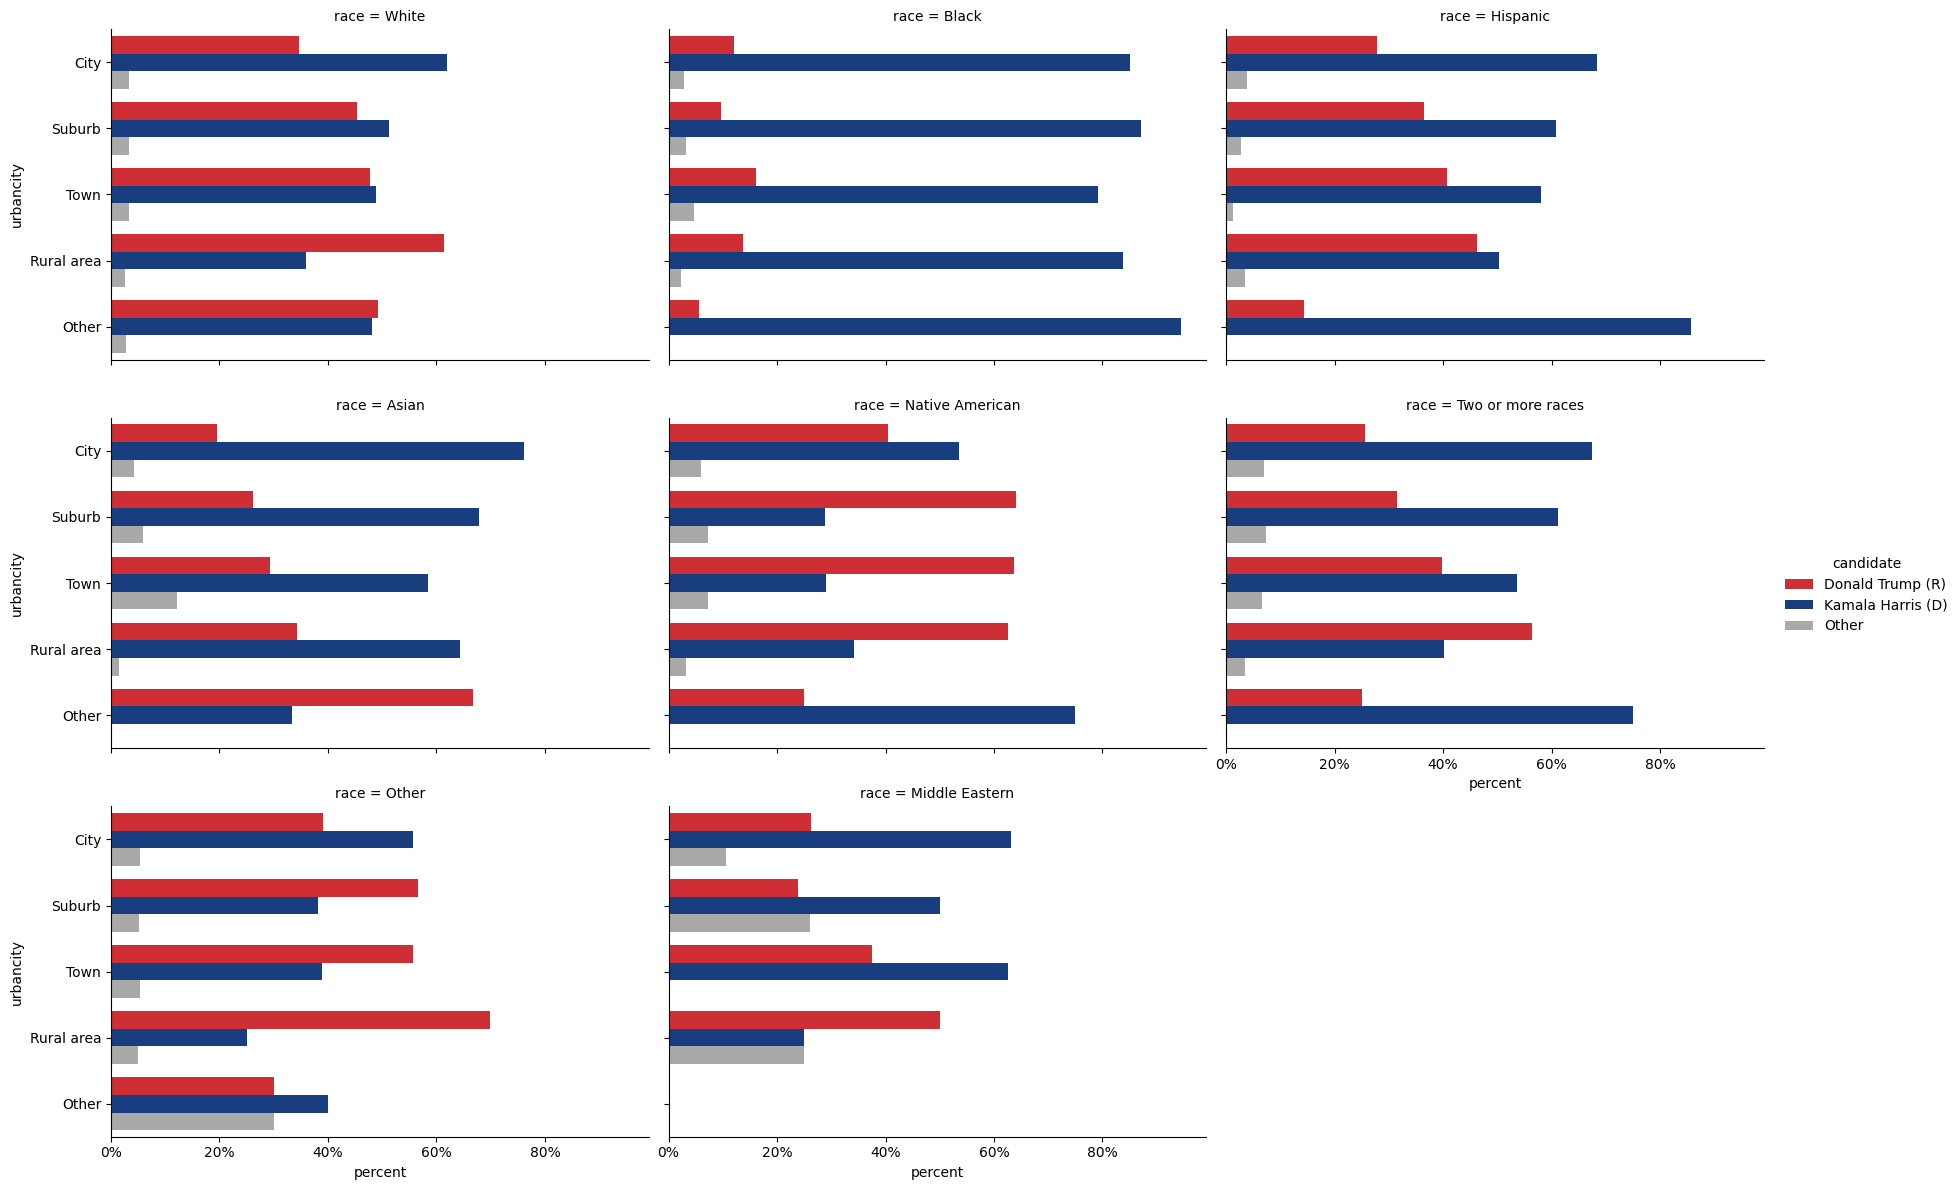

In [269]:
# race and urban
race_urban_vote_counts = pd.crosstab([ces24_df['urbancity'], ces24_df['race']], ces24_df['presvote24'])
race_urban_vote_prop = race_urban_vote_counts.div(race_urban_vote_counts.sum(axis=1), axis=0)
race_urban_vote_pct = race_urban_vote_prop * 100
race_urban_vote_long = race_urban_vote_pct.reset_index().melt(
    id_vars=['urbancity', 'race'],
    var_name='candidate',
    value_name='percent'
)
race_urban_plot = sns.catplot(
      data=race_urban_vote_long,
      x='percent',
      y='urbancity',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=3,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )

for ax in race_urban_plot.axes.flat:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

In [ ]:
# race and gender

In [ ]:
# race and education

#### Under-representation of Trump voters in 2024 CES survey dataset

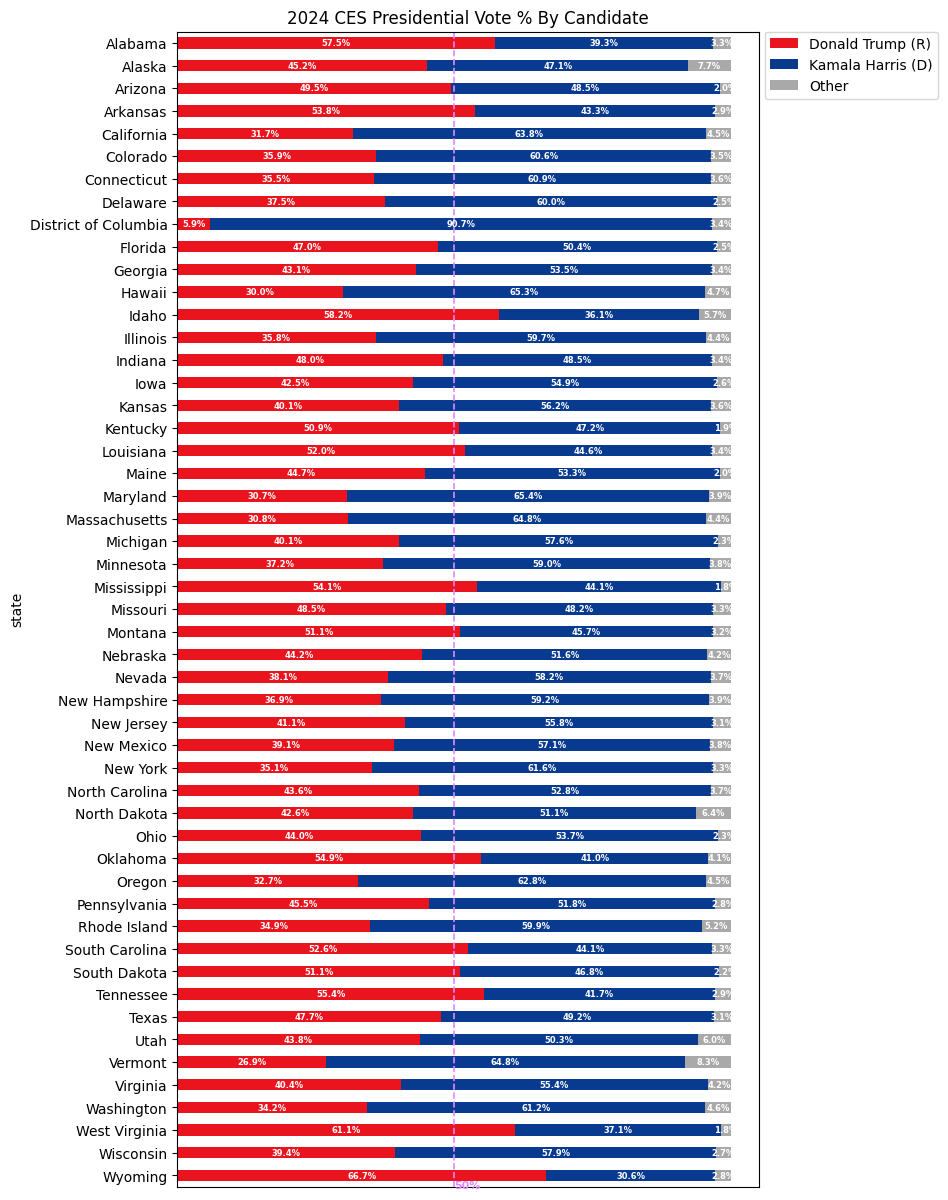

In [229]:
# state
state_vote_counts = pd.crosstab(ces24_df['state'], ces24_df['presvote24'])
state_vote_prop = state_vote_counts.div(state_vote_counts.sum(axis=1), axis=0)
state_vote_pct = state_vote_prop * 100
# state_vote_pct = state_vote_pct.sort_index()
# state_vote_pct
title = "2024 CES Presidential Vote % By Candidate"
plot_stacked_bar(state_vote_pct.sort_index(ascending=True).iloc[::-1],
                 figsize=(7.5, 15), label_fontsize=8, tick_fontsize=8,
                 legend_fontsize=9, title=title,
                 legend_position=(1.16, 1),
                 legend_ncol=1)

In [275]:
# state by state df
state_vote_pct.columns.name = None
ces_state_vote_pct_df = state_vote_pct.reset_index()
ces_state_vote_pct_df = ces_state_vote_pct_df.rename(columns={'index': 'state'})
ces_state_vote_pct_df

,state,Donald Trump (R),Kamala Harris (D),Other
0,Alabama,57.476636,39.252336,3.271028
1,Alaska,45.192308,47.115385,7.692308
2,Arizona,49.489796,48.469388,2.040816
3,Arkansas,53.805774,43.307087,2.887139
4,California,31.705964,63.772538,4.521498
5,Colorado,35.884567,60.602258,3.513174
6,Connecticut,35.520362,60.859729,3.619910
7,Delaware,37.500000,60.000000,2.500000
8,District of Columbia,5.932203,90.677966,3.389831
9,Florida,47.023986,50.429375,2.546639


In [274]:
# make another df to structure it similarly to the CES state by state
actual_state_vote_pct = results24_df[['state', 'state_abbrev', 'candidate_name', 'votes', 'percent']]
# make the results for both candidates show up in the same row
actual_state_vote_pct = actual_state_vote_pct.pivot(index='state', columns='candidate_name', values='percent')
# make it a pandas df
actual_state_vote_pct = pd.DataFrame(actual_state_vote_pct)
# remove the candidate_name and just have state, trump harris
actual_state_vote_pct = actual_state_vote_pct.reset_index()
actual_state_vote_pct = actual_state_vote_pct.rename(columns={'Donald Trump': 'Donald Trump (R)', 'Kamala Harris': 'Kamala Harris (D)'})
actual_state_vote_pct = actual_state_vote_pct[['state', 'Donald Trump (R)', 'Kamala Harris (D)']]
actual_state_vote_pct = actual_state_vote_pct.sort_values(by=['state'])
actual_state_vote_pct.columns.name = None
actual_state_vote_pct_df = actual_state_vote_pct.reset_index(drop=True)

# subset to only include states that do not contain "CD"
actual_state_vote_pct_df = actual_state_vote_pct_df[~actual_state_vote_pct_df['state'].str.contains('CD')]
# remove puerto rico
actual_state_vote_pct_df = actual_state_vote_pct_df[actual_state_vote_pct_df['state'] != 'Puerto Rico']

# code used for debugging
# ces_state_list = ces_state_vote_pct_df['state'].tolist()
# actual_state_list = actual_state_vote_pct_df['state'].tolist()
# diff = list(set(actual_state_list) - set(ces_state_list))
# the two should contain the same states
# actual_state_list == ces_state_list

# make a column for other/third party candidates

In [272]:
actual_state_vote_pct_df['Other'] = 100 - actual_state_vote_pct_df['Donald Trump (R)'] - actual_state_vote_pct_df['Kamala Harris (D)']
actual_state_vote_pct_df

,state,Donald Trump (R),Kamala Harris (D),Other
0,Alabama,64.572092,34.100720,1.327188
1,Alaska,54.544809,41.406128,4.049063
2,Arizona,52.217048,46.689818,1.093134
3,Arkansas,64.196872,33.559910,2.243218
4,California,38.332902,58.467704,3.199394
5,Colorado,43.142844,54.127686,2.729469
6,Connecticut,41.893906,56.398372,1.707722
7,Delaware,41.790989,56.492732,1.716279
8,District of Columbia,6.467630,90.277075,3.255296
9,Florida,56.088343,42.988293,0.923364


##### How this can be addressed
For the purposes of simplicity, I will down-sample Harris voters in the 2024 CES survey dataset. My next step will to be to examine different Bayesian methods for upsampling Trump voters.

## Models
Build logistic regression model to classify Trump and Harris voters.
Use the findings of Algara et al. and Kuriwaki et al. to choose variables that explain 2024 voting behavior.

$$
\text{vote_trump} = \sigma(\beta_0 + \beta_1 ....)
$$

In [ ]:
# Frequentist model selection

In [ ]:
# Bayesian model selection

## Results